In [205]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package punkt to /Users/natehiatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natehiatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natehiatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Cleaning EOs

In [51]:
# import EO csv file
eo_df = pd.read_csv('../data/executive_orders.csv', index_col=0)
eo_df.head()

,order_no,title,text,date
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933"
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933"
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933"
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933"
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933"


In [52]:
# creating a function to clean, tokenize, and lemmatize the text

def clean_text(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [53]:
# all text ends with "public domainpublic domainfalsefalse", so removing that
eo_df['text'] = eo_df['text'].str.replace('public domainpublic domainfalsefalse', '')
# apply function to our text
eo_df['cleaned_text'] = eo_df['text'].apply(clean_text)
eo_df.head()

,order_no,title,text,date,cleaned_text
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appointed, operative,..."
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law..."
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, 5, b, act..."
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, 401, 403, title, iv, part, ..."
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, ordered, executive, order, 1032, date..."


In [54]:
print(eo_df['cleaned_text'][1000])

['virtue', 'authority', 'vested', 'president', 'constitution', 'law', 'united', 'state', 'america', 'including', 'section', '3301', '3302', 'title', '5', 'united', 'state', 'code', 'order', 'improve', 'presidential', 'management', 'intern', 'program', 'providing', 'recruitment', 'selection', 'increasing', 'number', 'outstanding', 'employee', 'career', 'public', 'sector', 'management', 'hereby', 'ordered', 'section', '3', 'c', '1', 'executive', 'order', '12364', 'may', '24', '1982', 'amended', 'deleting', 'two', 'hundred', 'inserting', 'lieu', 'thereof', 'four', 'hundred', 'ronald', 'reaganthe', 'white', 'house', 'july', '12', '1988', 'filed', 'office', 'federal', 'register', '11', '33', 'july', '13', '1988']


In [55]:
eo_df['text_string'] = [' '.join(map(str, l)) for l in eo_df['cleaned_text']]
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appointed, operative,...",august gennerich may appointed operative secre...
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, 5, b, act...",virtue authority vested section 5 b act octobe...
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, 401, 403, title, iv, part, ...",whereas section 401 403 title iv part ii legis...
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, ordered, executive, order, 1032, date...",hereby ordered executive order 1032 dated febr...


# Laws

In [59]:
#importing data
laws_116 = pd.read_csv('../data/116_laws_text.csv')
laws_117 = pd.read_csv('../data/117_laws_text.csv')

In [60]:
# concatenating the two dataframes
laws = pd.concat([laws_116, laws_117], axis=0)
laws.reset_index()
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text
0,H.R. 8906,https://www.congress.gov/bill/116th-congress/h...,116,Lifespan Respite Care Reauthorization Act of 2020,"Langevin, James R. [Rep.-D-RI-2]",12/09/2020,hr,8906,This Act may be cited as the “Lifespan Respite...
1,H.R. 8900,https://www.congress.gov/bill/116th-congress/h...,116,"Further Continuing Appropriations Act, 2021, a...","Lowey, Nita M. [Rep.-D-NY-17]",12/08/2020,hr,8900,This Act may be cited as the “Further Continui...
2,H.R. 8810,https://www.congress.gov/bill/116th-congress/h...,116,National Landslide Preparedness Act,"DelBene, Suzan K. [Rep.-D-WA-1]",11/24/2020,hr,8810,This Act may be cited as the “National Landsli...
3,H.R. 8611,https://www.congress.gov/bill/116th-congress/h...,116,To designate the facility of the United States...,"Mast, Brian J. [Rep.-R-FL-18]",10/16/2020,hr,8611,The facility of the United States Postal Servi...
4,H.R. 8472,https://www.congress.gov/bill/116th-congress/h...,116,Impact Aid Coronavirus Relief Act,"Courtney, Joe [Rep.-D-CT-2]",10/01/2020,hr,8472,NaN


In [61]:
laws.iloc[0]

Legislation Number                                              H.R. 8906
URL                     https://www.congress.gov/bill/116th-congress/h...
Congress                                                              116
Title                   Lifespan Respite Care Reauthorization Act of 2020
Sponsor                                  Langevin, James R. [Rep.-D-RI-2]
Date of Introduction                                           12/09/2020
Chamber                                                                hr
Bill Number                                                          8906
Text                    This Act may be cited as the “Lifespan Respite...
Name: 0, dtype: object

In [34]:
laws.info()

<class 'pandas.core.frame.DataFrame'>
Index: 709 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Legislation Number    709 non-null    object
 1   URL                   709 non-null    object
 2   Congress              709 non-null    int64 
 3   Title                 709 non-null    object
 4   Sponsor               709 non-null    object
 5   Date of Introduction  709 non-null    object
 6   Chamber               709 non-null    object
 7   Bill Number           709 non-null    int64 
 8   Text                  630 non-null    object
dtypes: int64(2), object(7)
memory usage: 55.4+ KB


In [62]:
#dropping nulls
laws = laws.dropna(subset=['Text'])
laws["Text"].isna().sum()

0

In [63]:
laws.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Legislation Number    630 non-null    object
 1   URL                   630 non-null    object
 2   Congress              630 non-null    int64 
 3   Title                 630 non-null    object
 4   Sponsor               630 non-null    object
 5   Date of Introduction  630 non-null    object
 6   Chamber               630 non-null    object
 7   Bill Number           630 non-null    int64 
 8   Text                  630 non-null    object
dtypes: int64(2), object(7)
memory usage: 49.2+ KB


In [64]:
# process text
laws['cleaned_text'] = laws['Text'].apply(clean_text)
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text
0,H.R. 8906,https://www.congress.gov/bill/116th-congress/h...,116,Lifespan Respite Care Reauthorization Act of 2020,"Langevin, James R. [Rep.-D-RI-2]",12/09/2020,hr,8906,This Act may be cited as the “Lifespan Respite...,"[act, may, cited, lifespan, respite, care, rea..."
1,H.R. 8900,https://www.congress.gov/bill/116th-congress/h...,116,"Further Continuing Appropriations Act, 2021, a...","Lowey, Nita M. [Rep.-D-NY-17]",12/08/2020,hr,8900,This Act may be cited as the “Further Continui...,"[act, may, cited, continuing, appropriation, a..."
2,H.R. 8810,https://www.congress.gov/bill/116th-congress/h...,116,National Landslide Preparedness Act,"DelBene, Suzan K. [Rep.-D-WA-1]",11/24/2020,hr,8810,This Act may be cited as the “National Landsli...,"[act, may, cited, national, landslide, prepare..."
3,H.R. 8611,https://www.congress.gov/bill/116th-congress/h...,116,To designate the facility of the United States...,"Mast, Brian J. [Rep.-R-FL-18]",10/16/2020,hr,8611,The facility of the United States Postal Servi...,"[facility, united, state, postal, service, loc..."
5,H.R. 8354,https://www.congress.gov/bill/116th-congress/h...,116,Servicemembers and Veterans Initiative Act of ...,"Escobar, Veronica [Rep.-D-TX-16]",09/23/2020,hr,8354,This Act may be cited as the “Servicemembers a...,"[act, may, cited, servicemembers, veteran, ini..."


In [44]:
laws["cleaned_text"][0]

0    [act, may, cited, lifespan, respite, care, rea...
0    [facility, united, state, postal, service, loc...
Name: cleaned_text, dtype: object

In [65]:
laws['text_string'] = [' '.join(map(str, l)) for l in laws['cleaned_text']]
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text,text_string
0,H.R. 8906,https://www.congress.gov/bill/116th-congress/h...,116,Lifespan Respite Care Reauthorization Act of 2020,"Langevin, James R. [Rep.-D-RI-2]",12/09/2020,hr,8906,This Act may be cited as the “Lifespan Respite...,"[act, may, cited, lifespan, respite, care, rea...",act may cited lifespan respite care reauthoriz...
1,H.R. 8900,https://www.congress.gov/bill/116th-congress/h...,116,"Further Continuing Appropriations Act, 2021, a...","Lowey, Nita M. [Rep.-D-NY-17]",12/08/2020,hr,8900,This Act may be cited as the “Further Continui...,"[act, may, cited, continuing, appropriation, a...",act may cited continuing appropriation act 202...
2,H.R. 8810,https://www.congress.gov/bill/116th-congress/h...,116,National Landslide Preparedness Act,"DelBene, Suzan K. [Rep.-D-WA-1]",11/24/2020,hr,8810,This Act may be cited as the “National Landsli...,"[act, may, cited, national, landslide, prepare...",act may cited national landslide preparedness ...
3,H.R. 8611,https://www.congress.gov/bill/116th-congress/h...,116,To designate the facility of the United States...,"Mast, Brian J. [Rep.-R-FL-18]",10/16/2020,hr,8611,The facility of the United States Postal Servi...,"[facility, united, state, postal, service, loc...",facility united state postal service located 4...
5,H.R. 8354,https://www.congress.gov/bill/116th-congress/h...,116,Servicemembers and Veterans Initiative Act of ...,"Escobar, Veronica [Rep.-D-TX-16]",09/23/2020,hr,8354,This Act may be cited as the “Servicemembers a...,"[act, may, cited, servicemembers, veteran, ini...",act may cited servicemembers veteran initiativ...


In [66]:
# saving the cleaned data
laws.to_csv('../data/laws_cleaned.csv')
eo_df.to_csv('../data/eo_cleaned.csv')

# EDA and further filtering

## Executive Orders

In [76]:
fdist = FreqDist()

eo_df['tokens'] = [text.split(" ") for text in eo_df['text_string']]
for list in eo_df['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('order', 9446),
 ('shall', 9088),
 ('state', 8395),
 ('united', 6885),
 ('section', 6368),
 ('agency', 5723),
 ('c', 5153),
 ('president', 4813),
 ('act', 4564),
 ('law', 4255),
 ('executive', 4103),
 ('federal', 4026),
 ('secretary', 3874),
 ('1', 3796),
 ('authority', 3666),
 ('may', 3395),
 ('b', 3224),
 ('amended', 3056),
 ('hereby', 2991),
 ('2', 2891),
 ('u', 2776),
 ('service', 2742),
 ('national', 2683),
 ('government', 2546),
 ('department', 2473),
 ('sec', 2449),
 ('including', 2445),
 ('vested', 2443),
 ('3', 2314),
 ('follows', 2085),
 ('person', 1971),
 ('america', 1941),
 ('office', 1879),
 ('5', 1809),
 ('ordered', 1744),
 ('policy', 1730),
 ('constitution', 1714),
 ('information', 1692),
 ('public', 1614),
 ('appropriate', 1535),
 ('security', 1526),
 ('within', 1517),
 ('member', 1485),
 ('4', 1457),
 ('director', 1436),
 ('rule', 1411),
 ('function', 1401),
 ('general', 1389),
 ('program', 1383),
 ('action', 1377),
 ('employee', 1363),
 ('provision', 1344),
 ('regul

From this list, some words will clearly identify the document as an executive order, and others are unnecessary or simply artefacts of webscraping. We will remove those.

The expanded list of stopwords will include: "president", "executive," "order,"
["sec"]

Also numerals: "1", "2", "3", "4", "5", "6", "7", "8", "9" ...

And individual letters: "b", "u", "e", "r"

And the names of the presidents at hand: "franklin", "roosevelt", "harry", "truman", "dwight", "eisenhower", "john", "kennedy", "lyndon", "johnson", "richard", "nixon", "gerald", "ford", "jimmy", "carter", "ronald", "reagan", "george", "bush", "bill", "clinton", "barack", "obama", "donald", "trump", "joseph", "biden"


In [127]:
from nltk.corpus import stopwords
stops_extended = stopwords.words('english') + ['president', 'executive', 'order', 'b', "c", "d", "e", "f", "g",
                                               "h", "j", "k", 'u', 'r',
                                               "franklin", "roosevelt", "harry", "truman", "dwight", "eisenhower",
                                               "john", "kennedy", "lyndon", "johnson", "richard", "nixon", "gerald",
                                                "ford", "jimmy", "carter", "ronald", "reagan", "george", "bush", "bill",
                                                "clinton", "barack", "obama", "donald", "trump", "joseph", "biden",]

stops_extended

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [128]:
# creating a second version of text cleaning function to remove the extended stopwords and numbers     
def clean_text_2(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [141]:
# get clean version of the df and repeat intial filtering
eo_df = pd.read_csv('../data/executive_orders.csv', index_col=0)
eo_df['text'] = eo_df['text'].str.replace('public domainpublic domainfalsefalse', '')

# apply updated cleaning
eo_df['cleaned_text'] = eo_df['text'].apply(clean_text_2)

# create a text string column
eo_df['text_string'] = [' '.join(map(str, l)) for l in eo_df['cleaned_text']]
eo_df['target'] = 0
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string,target
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appointed, operative,...",august gennerich may appointed operative secre...,0
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...,0
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, act, octo...",virtue authority vested section act october st...,0
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, title, iv, part, ii, legisl...",whereas section title iv part ii legislative a...,0
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, ordered, dated, february, far, relate...",hereby ordered dated february far relates esta...,0


In [130]:
# Repeating the frequency distribution
eo_df['tokens'] = [text.split(" ") for text in eo_df['text_string']]
for list in eo_df['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('shall', 54528),
 ('state', 50370),
 ('united', 41310),
 ('section', 38208),
 ('agency', 34338),
 ('act', 27384),
 ('law', 25530),
 ('federal', 24156),
 ('secretary', 23244),
 ('authority', 21996),
 ('may', 20370),
 ('amended', 18336),
 ('hereby', 17946),
 ('service', 16452),
 ('national', 16098),
 ('government', 15276),
 ('department', 14838),
 ('sec', 14694),
 ('including', 14670),
 ('vested', 14658),
 ('follows', 12510),
 ('order', 12011),
 ('person', 11826),
 ('america', 11646),
 ('office', 11274),
 ('ordered', 10464),
 ('policy', 10380),
 ('c', 10306),
 ('constitution', 10284),
 ('information', 10152),
 ('public', 9684),
 ('appropriate', 9210),
 ('security', 9156),
 ('within', 9102),
 ('member', 8910),
 ('director', 8616),
 ('rule', 8466),
 ('function', 8406),
 ('general', 8334),
 ('program', 8298),
 ('action', 8262),
 ('employee', 8178),
 ('provision', 8064),
 ('regulation', 7902),
 ('defense', 7902),
 ('pursuant', 7812),
 ('emergency', 7800),
 ('title', 7782),
 ('committee', 7

## Laws
We'll now repeat this process for our laws dataframe.

In [133]:
laws['tokens'] = [text.split(" ") for text in laws['text_string']]
for list in laws['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('shall', 114701),
 ('section', 99286),
 ('state', 94131),
 ('united', 68836),
 ('act', 68373),
 ('secretary', 62515),
 ('agency', 51472),
 ('federal', 43212),
 ('may', 43150),
 ('law', 40442),
 ('service', 38822),
 ('c', 35547),
 ('subsection', 34008),
 ('including', 33941),
 ('department', 31985),
 ('program', 31893),
 ('authority', 31589),
 ('national', 31141),
 ('1', 30462),
 ('000', 29577),
 ('year', 29447),
 ('amended', 28553),
 ('sec', 26523),
 ('b', 26220),
 ('title', 25984),
 ('paragraph', 25938),
 ('government', 24286),
 ('provided', 23779),
 ('public', 23347),
 ('committee', 22477),
 ('information', 22278),
 ('defense', 21907),
 ('available', 21803),
 ('hereby', 21431),
 ('2', 21359),
 ('date', 20581),
 ('office', 20488),
 ('made', 19786),
 ('stat', 19716),
 ('security', 19521),
 ('report', 18713),
 ('fund', 18627),
 ('general', 18460),
 ('term', 18154),
 ('appropriate', 17855),
 ('code', 17668),
 ('person', 17334),
 ('amount', 17262),
 ('vested', 17144),
 ('plan', 16927),


In [160]:
# further stops
stops_extended_2 = stops_extended + ['congress']
# creating a third version of text cleaning function to remove the extended stopwords and numbers     
def clean_text_3(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended_2 and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [161]:
# apply updated cleaning
laws['cleaned_text'] = laws['Text'].apply(clean_text_3)

# create a text string column
laws['text_string'] = [' '.join(map(str, l)) for l in laws['cleaned_text']]
laws['target'] = 1
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text,text_string,tokens,target,year
0,H.R. 8906,https://www.congress.gov/bill/116th-congress/h...,116,Lifespan Respite Care Reauthorization Act of 2020,"Langevin, James R. [Rep.-D-RI-2]",12/09/2020,hr,8906,This Act may be cited as the “Lifespan Respite...,"[act, may, cited, lifespan, respite, care, rea...",act may cited lifespan respite care reauthoriz...,"[act, may, cited, lifespan, respite, care, rea...",1,2020
1,H.R. 8900,https://www.congress.gov/bill/116th-congress/h...,116,"Further Continuing Appropriations Act, 2021, a...","Lowey, Nita M. [Rep.-D-NY-17]",12/08/2020,hr,8900,This Act may be cited as the “Further Continui...,"[act, may, cited, continuing, appropriation, a...",act may cited continuing appropriation act ext...,"[act, may, cited, continuing, appropriation, a...",1,2020
2,H.R. 8810,https://www.congress.gov/bill/116th-congress/h...,116,National Landslide Preparedness Act,"DelBene, Suzan K. [Rep.-D-WA-1]",11/24/2020,hr,8810,This Act may be cited as the “National Landsli...,"[act, may, cited, national, landslide, prepare...",act may cited national landslide preparedness ...,"[act, may, cited, national, landslide, prepare...",1,2020
3,H.R. 8611,https://www.congress.gov/bill/116th-congress/h...,116,To designate the facility of the United States...,"Mast, Brian J. [Rep.-R-FL-18]",10/16/2020,hr,8611,The facility of the United States Postal Servi...,"[facility, united, state, postal, service, loc...",facility united state postal service located s...,"[facility, united, state, postal, service, loc...",1,2020
5,H.R. 8354,https://www.congress.gov/bill/116th-congress/h...,116,Servicemembers and Veterans Initiative Act of ...,"Escobar, Veronica [Rep.-D-TX-16]",09/23/2020,hr,8354,This Act may be cited as the “Servicemembers a...,"[act, may, cited, servicemembers, veteran, ini...",act may cited servicemembers veteran initiativ...,"[act, may, cited, servicemembers, veteran, ini...",1,2020


In [136]:
# Repeating the frequency distribution
laws['tokens'] = [text.split(" ") for text in laws['text_string']]
for list in laws['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('shall', 165786),
 ('section', 153996),
 ('state', 129497),
 ('act', 104798),
 ('secretary', 97912),
 ('united', 89477),
 ('agency', 62883),
 ('may', 62535),
 ('subsection', 60498),
 ('service', 58450),
 ('federal', 58242),
 ('program', 54105),
 ('year', 53847),
 ('law', 51099),
 ('including', 50767),
 ('paragraph', 47235),
 ('department', 46659),
 ('national', 43501),
 ('title', 42889),
 ('provided', 41419),
 ('available', 40715),
 ('authority', 37516),
 ('committee', 35945),
 ('sec', 35903),
 ('amended', 35714),
 ('stat', 35624),
 ('c', 35547),
 ('public', 35396),
 ('defense', 34595),
 ('fund', 34517),
 ('date', 33476),
 ('amount', 33047),
 ('information', 32712),
 ('made', 32348),
 ('term', 31681),
 ('government', 30750),
 ('1', 30463),
 ('000', 29577),
 ('inserting', 29377),
 ('report', 28879),
 ('plan', 28779),
 ('security', 28360),
 ('office', 27823),
 ('described', 27813),
 ('code', 27559),
 ('health', 27543),
 ('general', 27197),
 ('b', 26220),
 ('fiscal', 26171),
 ('activity

# Both

In [144]:
# add year column
eo_df['year'] = pd.to_datetime(eo_df['date']).dt.year
#eo_df['year'] = eo_df['year'].astype(int)
laws['year'] = pd.to_datetime(laws['Date of Introduction']).dt.year

In [145]:
eo_df[eo_df['year'].isna()]

,order_no,title,text,date,cleaned_text,text_string,target,year
337,10338,NaN,by virtue of the authority vested in me by sec...,NaN,"[virtue, authority, vested, section, mutual, s...",virtue authority vested section mutual securit...,0,NaN
338,10339,NaN,by virtue of the authority vested in me by sec...,NaN,"[virtue, authority, vested, section, act, enti...",virtue authority vested section act entitled a...,0,NaN
548,11515,NaN,"march 13, 1970 by virtue of the authority ves...",NaN,"[march, virtue, authority, vested, united, sta...",march virtue authority vested united state her...,0,NaN
2052,13704,NaN,federal register part iii the president exe...,NaN,"[federal, register, part, iii, presidential, i...",federal register part iii presidential innovat...,0,NaN
2134,13866,NaN,please see this document's talk page for detai...,NaN,"[please, see, document, talk, page, detail, ve...",please see document talk page detail verificat...,0,NaN
2158,13962,NaN,"executive order 13962 of december 8, 2020 ensu...",NaN,"[december, ensuring, access, united, state, go...",december ensuring access united state governme...,0,NaN


In [146]:
# order 103338 https://www.presidency.ucsb.edu/documents/executive-order-10338-coordination-procedures-under-section-507-the-mutual-security-act
eo_df.at[337, 'date'] = 'April 4, 1952'
eo_df.at[337, 'year'] = 1952
eo_df.at[337, 'title'] = 'Coordination Procedures Under Section 507 of the Mutual Security Act of 1951'

# order 10339 https://www.archives.gov/federal-register/executive-orders/1952.html#10339
eo_df.at[338, 'date'] = 'April 4, 1952'
eo_df.at[338, 'year'] = 1952
eo_df.at[338, 'title'] = 'Extensions of Time Relating to the Disposition of Certain Housing'

# order 11515
eo_df.at[548, 'date'] = 'March 13, 1970'
eo_df.at[548, 'year'] = 1970

# order 13704 https://www.govinfo.gov/content/pkg/DCPD-201500563/pdf/DCPD-201500563.pdf
eo_df.at[2052, 'date'] = 'August 17, 2015'
eo_df.at[2052, 'year'] = 2015
eo_df.at[2052, 'title'] = 'Presidential Innovation Fellows Program'


# order 13866 https://www.presidency.ucsb.edu/documents/executive-order-13866-adjustments-certain-rates-pay
eo_df.at[2134, 'date'] = 'March 28, 2019'
eo_df.at[2134, 'year'] = 2019
eo_df.at[2134, 'title'] = 'Adjustments of Certain Rates of Pay'

# order 13867 https://www.federalregister.gov/documents/2019/04/15/2019-07645/issuance-of-permits-with-respect-to-facilities-and-land-transportation-crossings-at-the
eo_df.at[2135, 'date'] = 'April 10, 2019'
eo_df.at[2135, 'year'] = 2019
eo_df.at[2135, 'title'] = 'Issuance of Permits with Respect to Facilities and Land Transportation Crossings at the International Boundaries of the United States'

# order 13962 https://www.presidency.ucsb.edu/documents/executive-order-13962-ensuring-access-united-states-government-covid-19-vaccines
eo_df.at[2158, 'date'] = 'December 8, 2020'
eo_df.at[2158, 'year'] = 2020
eo_df.at[2158, 'title'] = 'Ensuring Access to United States Government COVID-19 Vaccines'

In [147]:
eo_df.isna().sum()

order_no        0
title           9
text            0
date            0
cleaned_text    0
text_string     0
target          0
year            0
dtype: int64

In [156]:
# Also adding the president responsible for a given order
# https://www.presidency.ucsb.edu/statistics/data/executive-orders

def assign_president(order_no):
    if order_no <= 9537:
        return 'roosevelt'
    elif order_no <= 10431:
        return 'truman'
    elif order_no <= 10913:
        return 'eisenhower'
    elif order_no <= 11127:
        return 'kennedy'
    elif order_no <= 11451:
        return 'johnson'
    elif order_no <= 11797:
        return 'nixon'
    elif order_no <= 11966:
        return 'ford'
    elif order_no <= 12286:
        return 'carter'
    elif order_no <= 12667:
        return 'reagan'
    elif order_no <= 12833:
        return 'bush 1'
    elif order_no <= 13197:
        return 'clinton'
    elif order_no <= 13488:
        return 'bush 2'
    elif order_no <= 13764:
        return 'obama'
    elif order_no <= 13984:
        return 'trump'
    else:
        return 'biden'

eo_df['president'] = eo_df['order_no'].apply(assign_president)


    

In [158]:
eo_df['president'].value_counts()

president
reagan        381
clinton       364
bush 2        291
obama         218
roosevelt     186
truman        173
bush 1        166
trump         109
eisenhower     94
biden          82
kennedy        57
carter         51
nixon          37
johnson        31
ford           13
Name: count, dtype: int64

In [149]:
laws.isna().sum()

Legislation Number      0
URL                     0
Congress                0
Title                   0
Sponsor                 0
Date of Introduction    0
Chamber                 0
Bill Number             0
Text                    0
cleaned_text            0
text_string             0
tokens                  0
target                  0
year                    0
dtype: int64

We'll now go ahead and resave the dataframes:

In [162]:
# saving the cleaned data
laws.to_csv('../data/laws_cleaned.csv')
eo_df.to_csv('../data/eo_cleaned.csv')

# Modelling

In [172]:
# starting off with some functions we'll keep using
def evaluate_grid(gs):
    y_pred = gs.predict(X_test)
    print("Best Params: " + str(gs.best_params_)) 
    print("Best CV Accuracy: " + str(gs.best_score_)) 
    print("Train Accuracy: " + str(gs.score(X_train, y_train)))

def plot_cm(y_test, gs):
    '''
    Takes in true values and predicted values and plots a confusion matrix
    '''
    y_pred = gs.predict(X_test)    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Executive Order', 'Legislation'])
    disp.plot();

In [175]:
# combining the dataframes
filtered_eo = eo_df[['year', 'text_string', 'target']]
filtered_laws = laws[['year', 'text_string', 'target']]
df = pd.concat([filtered_eo, filtered_laws])
# setting year as integer
df['year'] = df['year'].astype(int)
# creating a list of tokens
df['tokens'] = [text.split(" ") for text in df['text_string']]
df

,year,text_string,target,tokens
0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,..."
1,1933,canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law..."
2,1933,virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo..."
3,1933,whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl..."
4,1933,hereby ordered dated february far relates esta...,0,"[hereby, ordered, dated, february, far, relate..."
...,...,...,...,...
360,2022,act may cited vawa technical amendment act sub...,1,"[act, may, cited, vawa, technical, amendment, ..."
361,2021,limitation section title united state code rec...,1,"[limitation, section, title, united, state, co..."
362,2021,disapproves rule submitted office comptroller ...,1,"[disapproves, rule, submitted, office, comptro..."
363,2021,disapproves rule submitted administrator envir...,1,"[disapproves, rule, submitted, administrator, ..."


In [165]:
X = df['text_string']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [186]:
# creating a pipeline
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# setting up the parameters
param_grid_nb = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
    'tfidf__min_df': [1, 3, 5, 10],
    'nb__alpha': [0.01, 0.1, 1]
}

# grid search
gs_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, n_jobs=-1)

In [187]:
gs_nb.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.01, 0.1, 1],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 3, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (2, 3), (3, 3)]})

In [188]:
evaluate_grid(gs_nb)

Best Params: {'nb__alpha': 0.01, 'tfidf__max_df': 1.0, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3)}
Best CV Accuracy: 0.9956653613920425
Train Accuracy: 1.0


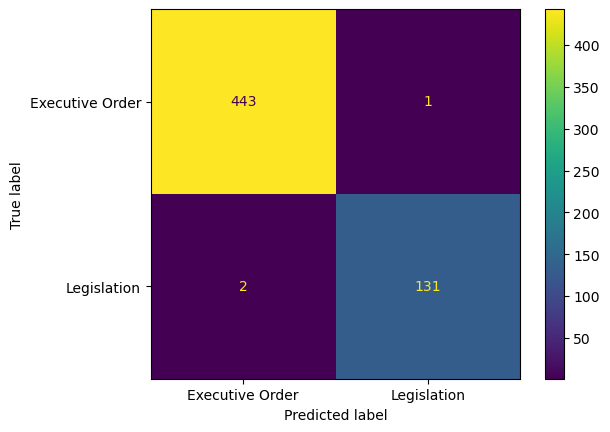

In [189]:
plot_cm(y_test, gs_nb)

,year,text_string,target
0,1933,august gennerich may appointed operative secre...,0
1,1933,canal zoneby virtue authority vested law hereb...,0
2,1933,virtue authority vested section act october st...,0
3,1933,whereas section title iv part ii legislative a...,0
4,1933,hereby ordered dated february far relates esta...,0


In [197]:
# instantiate vectorizer
# using params from grid search
tfidf_nb = TfidfVectorizer(max_df=1.0, min_df=3, ngram_range=(1, 3))
X_train_tfidf_nb = tfidf_nb.fit_transform(X_train)
X_test_tfidf_nb = tfidf_nb.transform(X_test)

# fitting to Naive Bayes classifier
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train_tfidf_nb, y_train)
#y_pred_nb = nb.predict(X_test_tfidf_nb)

# Creating tfidf matrix:
X_tfidf_nb = tfidf_nb.transform(df['text_string'])
result_df = df.copy()
result_df.reset_index(inplace=True)
result_df["tfidf"] = X_tfidf_nb.toarray().tolist()
result_df.head()

,index,year,text_string,target,tokens,tfidf
0,0,1933,august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1933,canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,1933,virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,1933,whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1933,hereby ordered dated february far relates esta...,0,"[hereby, ordered, dated, february, far, relate...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [203]:
print(result_df["tfidf"][1])

[0.46554184815027305, 0.25228590558910424, 0.22753064663418796, 0.20513818916964174, 0.19891653360013686, 0.1895350643502799, 0.18581196176571868, 0.17959030619621377, 0.1769328818273818, 0.1745068434540141, 0.1745068434540141, 0.17227510449018416, 0.1702088369463568, 0.16320172514230952, 0.15636725693899498, 0.14895896048058613, 0.14715950695787253, 0.14630153611175414, 0.14630153611175414, 0.13828042701953563, 0.13416406188677066, 0.13309155072101705, 0.12161162398444451, 0.12077536853076475, 0.11595325731914881, 0.11273254404610764, 0.10620836993090528, 0.09592467911459365, 0.09366094720125835, 0.09121360057126719, 0.08648382357511916, 0.07765872594296691, 0.07680730551445995, 0.07666789596184924, 0.07278946407970002, 0.0718873731673441, 0.04619926264384501, 0.04587478189600151, 0.042514068769997373, 0.037669936702738625, 0.03597153175918089, 0.03579440128947353, 0.034188236945951564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [204]:
tfidf_nb.get_feature_names_out()

array(['100th', '1011c', '102a', ..., 'état', 'état decree',
       'état decree date'], dtype=object)

In [212]:
features_nb.sort_values(by="diff", ascending=True).head(20)

,0,1,2,diff
25348,authority vested,-6.182932,-13.668819,-7.485887
94191,hereby ordered,-6.240774,-13.682191,-7.441417
216830,vested constitution,-6.283429,-13.682191,-7.398762
25353,authority vested constitution,-6.285894,-13.682191,-7.396297
134573,ordered follows,-6.305485,-13.682191,-7.376706
216831,vested constitution law,-6.305869,-13.682191,-7.376322
94198,hereby ordered follows,-6.348832,-13.682191,-7.333359
15058,america including,-6.748077,-13.682191,-6.934114
193221,state america including,-6.749092,-13.682191,-6.933099
46112,constitution law united,-6.298572,-13.068656,-6.770084


Text(50.7222222222222, 0.5, '')

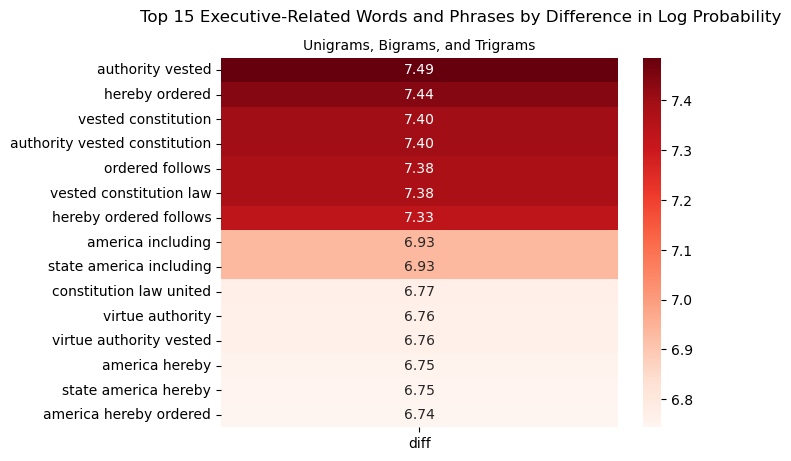

In [219]:
features_nb = pd.DataFrame((zip(tfidf_nb.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb["diff"] = features_nb[2] - features_nb[1]

heatmap_nb = features_nb[[0, "diff"]].copy()
heatmap_nb = heatmap_nb.rename(columns={0: "word"})
heatmap_nb = heatmap_nb.sort_values(by="diff", ascending=True)
heatmap_nb = heatmap_nb.set_index("word")
heatmap_nb

sns.heatmap(heatmap_nb[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams, Bigrams, and Trigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")


In [214]:
features_nb.sort_values(by="diff", ascending=True).head(50)

,0,1,2,diff
25348,authority vested,-6.182932,-13.668819,-7.485887
94191,hereby ordered,-6.240774,-13.682191,-7.441417
216830,vested constitution,-6.283429,-13.682191,-7.398762
25353,authority vested constitution,-6.285894,-13.682191,-7.396297
134573,ordered follows,-6.305485,-13.682191,-7.376706
216831,vested constitution law,-6.305869,-13.682191,-7.376322
94198,hereby ordered follows,-6.348832,-13.682191,-7.333359
15058,america including,-6.748077,-13.682191,-6.934114
193221,state america including,-6.749092,-13.682191,-6.933099
46112,constitution law united,-6.298572,-13.068656,-6.770084


Words that we'll use to further filter the corpus:

Artefacts: "reaganthe"

Presidency-related: "commander", "chief"

Authority-related: "authority", "vested", "constitution"

Other: "state", "ordered", "follows", "hereby", "united", "states", "white", "house"

Text(50.7222222222222, 0.5, '')

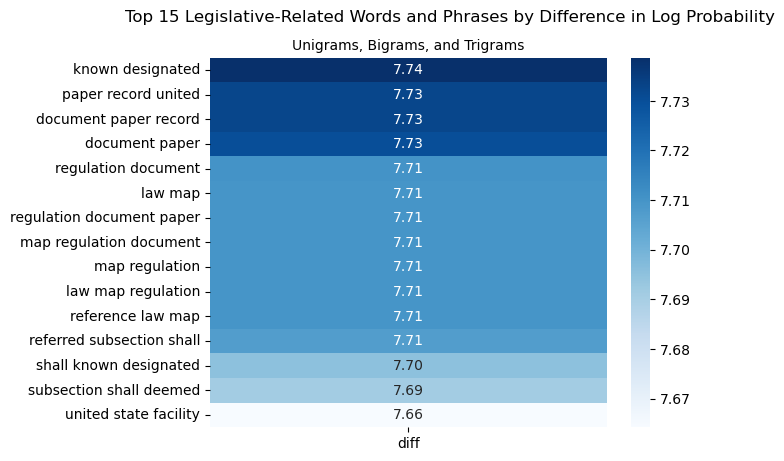

In [218]:
heatmap_nb = features_nb[[0, "diff"]].copy()
heatmap_nb = heatmap_nb.rename(columns={0: "word"})
heatmap_nb = heatmap_nb.sort_values(by="diff", ascending=False)
heatmap_nb = heatmap_nb.set_index("word")
heatmap_nb

sns.heatmap(heatmap_nb[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams, Bigrams, and Trigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

In [222]:
heatmap_nb.sort_values(by="diff", ascending=False).head(50)

,diff
word,
known designated,7.738676
paper record united,7.732316
document paper record,7.732287
document paper,7.730237
regulation document,7.710272
law map,7.709725
regulation document paper,7.709693
reference law map,7.709691
map regulation,7.709691


# drop the necessary strings from the different text/tokens in the df, calculate how each row goes into the next df

# first run this with some different models?

In [234]:
from sklearn.ensemble import RandomForestClassifier
# instantiate vectorizer
# using params from grid search

X = df[['text_string']]
y = df['target']

# creating a pipeline
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# setting up the parameters
param_grid_rf = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 3, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
    'rf__n_estimators': [100, 200, 300],
    'rf__criterion': ['gini', 'log_loss'],
    'rf__max_depth': [None, 10, 50],
    'rf__max_features': [None, 'sqrt', 'log2']
}

# grid search
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, n_jobs=-1)

In [235]:
gs_rf.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 